In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

2025-10-08 08:54:28.245908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759913668.471859      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759913668.538218      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ticker = 'AAPL'  
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
data = data['Close'].values.reshape(-1, 1)

/tmp/ipykernel_37/3603964004.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
def create_dataset(data, time_step=60):
    X, y = [],[]
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
X, y = create_dataset(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [8]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.fit(X_train, y_train, epochs=20, batch_size=64)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1956
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0132
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0044
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.3872e-04
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.1208e-04
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.2909e-04
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5337e-04
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.0636e-04
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8415e-04
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4911e-04
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.1063e-04
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.5463e-04
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.4810e-04
Epoch 15/20
15/15 ━━━━━━━━━━━━━

In [12]:
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)

print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")

Unscaled Mean Squared Error (MSE): 110.35997127595957
Unscaled Root Mean Squared Error (RMSE): 10.505235422205423
Unscaled Mean Absolute Error (MAE): 8.423964500427244


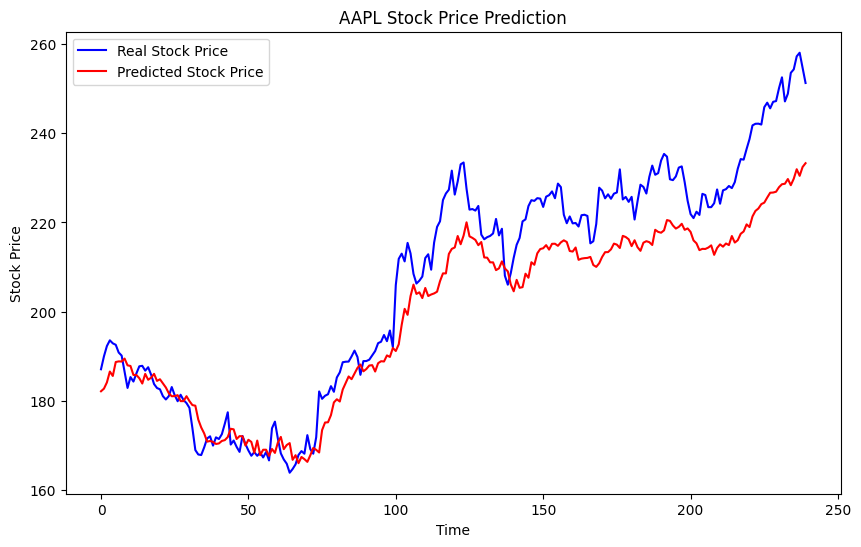

In [13]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()